<a href="https://colab.research.google.com/github/KetkiGupta99/Credit_Score_Analysis/blob/main/Credit_Score_Rough_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
pip install xgboost


In [88]:
import json
import pandas as pd

with open("/content/user-wallet-transactions.json") as f:
    data = json.load(f)

df = pd.json_normalize(data)


In [89]:
df.head()

,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,__v,_id.$oid,...,actionData.repayerId,actionData.liquidatorId,actionData.collateralAmount,actionData.collateralAssetPriceUSD,actionData.principalAmount,actionData.borrowAssetPriceUSD,actionData.collateralReserveId,actionData.collateralReserveSymbol,actionData.principalReserveId,actionData.principalReserveSymbol
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,0,681d38fed63812d4655f571a,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,0,681aa70dd6df53021cc6f3c0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,0,681d04c2d63812d4654c733e,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,0,681d133bd63812d46551b6ef,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,0,681899e4ba49fc91cf2f4454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
# Rename for clarity
df["amount"] = df["actionData.amount"].astype(float) / 1e6  # Convert to USDC
df["price_usd"] = df["actionData.assetPriceUSD"].astype(float)
df["usd_value"] = df["amount"] * df["price_usd"]

# Clean action names
df["action"] = df["action"].str.lower()


In [91]:
# Create boolean columns per action
df["is_deposit"] = df["action"] == "deposit"
df["is_borrow"] = df["action"] == "borrow"
df["is_repay"] = df["action"] == "repay"
df["is_liquidation"] = df["action"] == "liquidationcall"


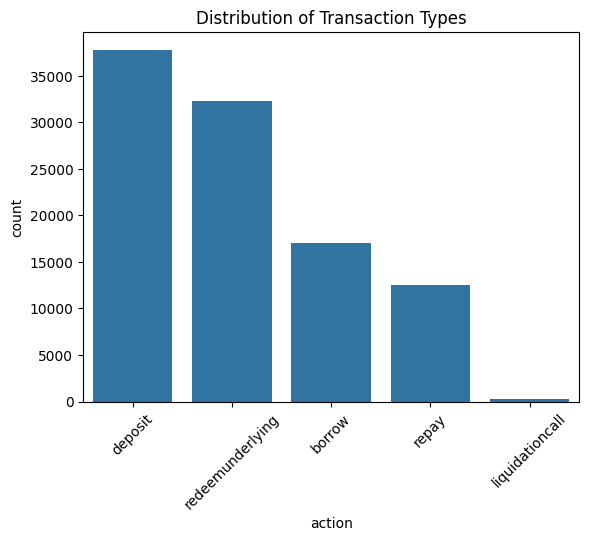

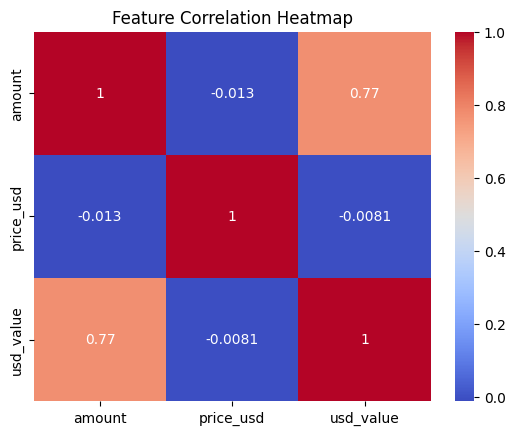

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Transaction Type Count
sns.countplot(data=df, x="action")
plt.title("Distribution of Transaction Types")
plt.xticks(rotation=45)
plt.show()

# Correlation Heatmap
correlation = df[["amount", "price_usd", "usd_value"]].corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


In [93]:
wallet_df = df.groupby("userWallet").agg({
    "usd_value": ["sum", "mean"],
    "is_deposit": "sum",
    "is_borrow": "sum",
    "is_repay": "sum",
    "is_liquidation": "sum",
    "timestamp": ["min", "max", "count"]
})

wallet_df.columns = ["_".join(col).strip() for col in wallet_df.columns.values]
wallet_df.reset_index(inplace=True)

# Create derived features
wallet_df["repay_ratio"] = wallet_df["is_repay_sum"] / wallet_df["is_borrow_sum"].replace(0, 1)
wallet_df["liquidation_rate"] = wallet_df["is_liquidation_sum"] / wallet_df["is_borrow_sum"].replace(0, 1)
wallet_df["borrow_to_deposit_ratio"] = wallet_df["is_borrow_sum"] / wallet_df["is_deposit_sum"].replace(0, 1)
wallet_df["active_days"] = (wallet_df["timestamp_max"] - wallet_df["timestamp_min"]) / (60*60*24)


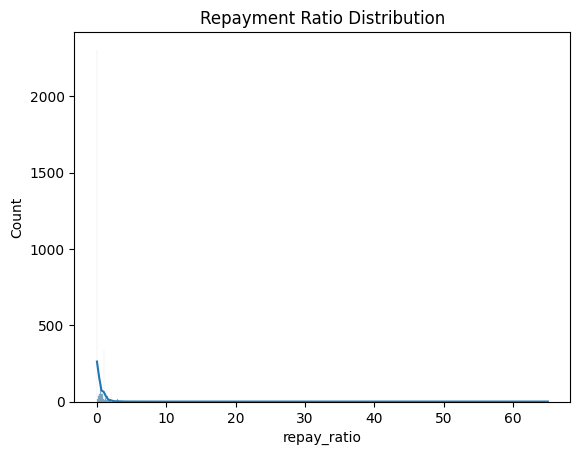

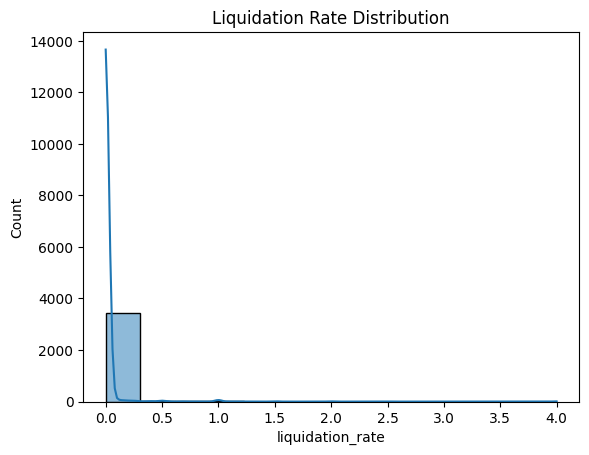

In [94]:
sns.histplot(wallet_df["repay_ratio"], kde=True)
plt.title("Repayment Ratio Distribution")
plt.show()

sns.histplot(wallet_df["liquidation_rate"], kde=True)
plt.title("Liquidation Rate Distribution")
plt.show()


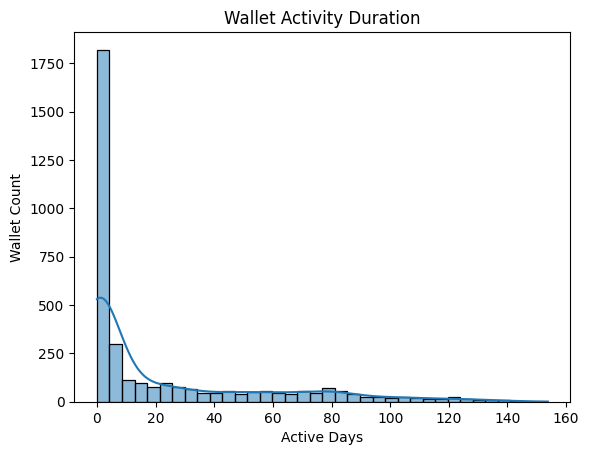

In [96]:
wallet_df["active_days"] = (wallet_df["timestamp_max"] - wallet_df["timestamp_min"]) / (60*60*24)

sns.histplot(wallet_df["active_days"], kde=True)
plt.title("Wallet Activity Duration")
plt.xlabel("Active Days")
plt.ylabel("Wallet Count")
plt.show()


In [98]:
list(df.columns)

['userWallet',
 'network',
 'protocol',
 'txHash',
 'logId',
 'timestamp',
 'blockNumber',
 'action',
 '__v',
 '_id.$oid',
 'actionData.type',
 'actionData.amount',
 'actionData.assetSymbol',
 'actionData.assetPriceUSD',
 'actionData.poolId',
 'actionData.userId',
 'createdAt.$date',
 'updatedAt.$date',
 'actionData.toId',
 'actionData.borrowRateMode',
 'actionData.borrowRate',
 'actionData.variableTokenDebt',
 'actionData.stableTokenDebt',
 'actionData.callerId',
 'actionData.useATokens',
 'actionData.repayerId',
 'actionData.liquidatorId',
 'actionData.collateralAmount',
 'actionData.collateralAssetPriceUSD',
 'actionData.principalAmount',
 'actionData.borrowAssetPriceUSD',
 'actionData.collateralReserveId',
 'actionData.collateralReserveSymbol',
 'actionData.principalReserveId',
 'actionData.principalReserveSymbol',
 'amount',
 'price_usd',
 'usd_value',
 'is_deposit',
 'is_borrow',
 'is_repay',
 'is_liquidation']

In [100]:
def score_wallet(row):
    score = (
        row["usd_value_sum"] * 0.1 +
        row["repay_ratio"] * 300 -
        row["liquidation_rate"] * 500 +
        row["active_days"] * 2
    )
    return max(0, min(1000, int(score)))

wallet_df["credit_score"] = wallet_df.apply(score_wallet, axis=1)


In [101]:
import pandas as pd


features = [
    "usd_value_sum", "usd_value_mean", "is_deposit_sum",
    "is_borrow_sum", "is_repay_sum", "is_liquidation_sum",
    "repay_ratio", "liquidation_rate", "borrow_to_deposit_ratio",
    "active_days"
]

X = wallet_df[features]


y = wallet_df["credit_score"]


In [114]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [120]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1)
}

In [121]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = {"MSE": mse, "R²": r2}


In [122]:
result_df = pd.DataFrame(results).T
print(result_df)


                             MSE        R²
Random Forest       12796.354995  0.911109
Gradient Boosting   14042.272723  0.902454
Decision Tree       17421.609027  0.878980
XGBoost             16935.033203  0.882360
Ridge Regression   141947.918796  0.013950
Lasso Regression   141848.256495  0.014642


In [123]:
best_model = models["Random Forest"]
wallet_df["ml_pred_score"] = best_model.predict(scaler.transform(X))

min_score = wallet_df["ml_pred_score"].min()
max_score = wallet_df["ml_pred_score"].max()

wallet_df["ml_credit_score"] = ((wallet_df["ml_pred_score"] - min_score) / (max_score - min_score) * 1000).astype(int)


In [107]:
wallet_scores = dict(zip(wallet_df["userWallet"], wallet_df["ml_credit_score"]))
with open("ml_wallet_scores.json", "w") as f:
    json.dump(wallet_scores, f, indent=2)


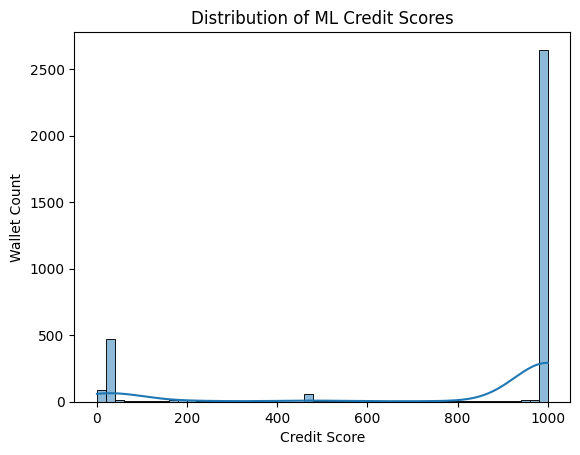

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(wallet_df["ml_credit_score"], bins=50, kde=True)
plt.title("Distribution of ML Credit Scores")
plt.xlabel("Credit Score")
plt.ylabel("Wallet Count")
plt.show()


/tmp/ipython-input-125-2767596308.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bucket_counts.index, y=bucket_counts.values, palette="viridis")


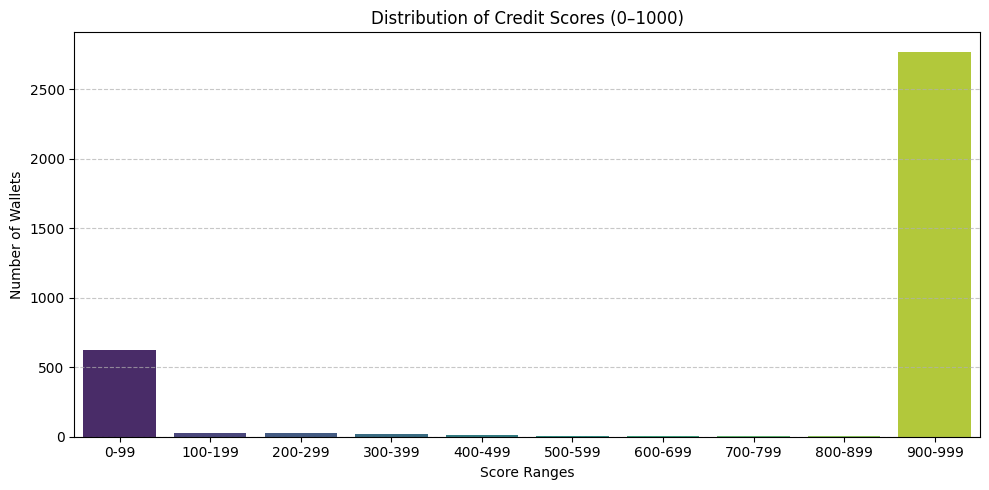

In [125]:

bins = list(range(0, 1100, 100))
labels = [f"{i}-{i+99}" for i in bins[:-1]]

wallet_df["score_bucket"] = pd.cut(wallet_df["credit_score"], bins=bins, labels=labels, include_lowest=True)


bucket_counts = wallet_df["score_bucket"].value_counts().sort_index()

print(bucket_counts)

plt.figure(figsize=(10, 5))
sns.barplot(x=bucket_counts.index, y=bucket_counts.values, palette="viridis")

plt.title("Distribution of Credit Scores (0–1000)")
plt.xlabel("Score Ranges")
plt.ylabel("Number of Wallets")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
